In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/GITHUB/pytorch_basic/pytorch
from mult_class_functions_1 import *

Mounted at /content/drive
/content/drive/MyDrive/GITHUB/pytorch_basic/pytorch


In [2]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import copy
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cuda


In [3]:
def im_plot(DL):
    x_batch, y_batch = next(iter(DL))
    plt.figure(figsize=(8,4))
    for idx in range(6):
        plt.subplot(2,3, idx+1, xticks = [], yticks = [])
        plt.imshow(x_batch[idx,...].permute(1,2,0).squeeze())
        true_class = DL.dataset.classes[y_batch[idx].item()]
        plt.title(true_class, color="g")

In [4]:
BATCH_SIZE = 32
transform_train = transforms.ToTensor()
transform_test = transforms.ToTensor()
train_DS = datasets.STL10(root = '/content/drive/MyDrive/Colab notebooks/data', split = "train", download = True, transform = transform_train)
test_DS = datasets.STL10(root = '/content/drive/MyDrive/Colab notebooks/data', split = "test", download = True, transform = transform_test)
train_DL = torch.utils.data.DataLoader(train_DS, batch_size = BATCH_SIZE, shuffle = True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size = BATCH_SIZE, shuffle = False)

Files already downloaded and verified
Files already downloaded and verified


image shape = (3, 96, 96)
augmentation image shape = (3, 96, 96)


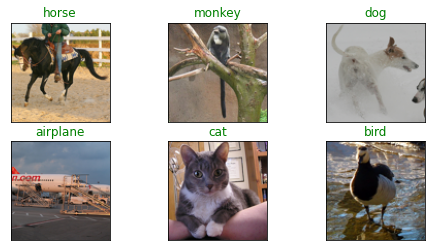

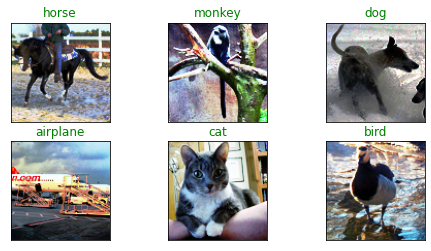

In [6]:
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x:(255*x).type(torch.uint8)),
    # transforms.Lambda(to_uint8), # 가능
    # to_uint8, # 가능
    # lambda x:(255*x).type(torch.uint8), # 가능
    #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    # (아마도) 이미지넷 데이터 전체 픽셀에 대해서 구한 평균, std 값

    # transforms.Resize(size=(30,30)), # size는 (height, width)
    # transforms.CenterCrop(size=(30,30))
    # transforms.Pad(18) # 60+18*18
    # transforms.RandomApply(nn.ModuleList([transforms.CenterCrop(size=(60,60)),
    #                                       transforms.Pad(18)]), p=0.3),
    # transforms.RandomCrop(size=(30,30)), # 어디를 자를지 random 하게 자름
    # transforms.RandomResizedCrop(size=(60,60), scale=(0.3,1), ratio=(0.75, 1.3)),
    # random 하게 자른 다음에 resize하는 거라서 RandomCrop과 다름
    # scale은 어느 정도로 작은 범위를 자를지 (0~1 사이 값)
    # ratio는 aspect ratio, 가로 길이/세로 길이 를 의미

    # transforms.RandomGrayscale(p=0.3), # gray로 바꾸는 데, 출력 채널 수를 3으로 유지
    # transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.5, hue=0.3),
    # 밝기, 대비, 채도, 색조가 센서마다 다를 수 있음을 고려 (number: percentage to convert)
    # 밝기(brightness)를 키우면 밝은 부분 saturation이 일어나면서, HDR이 낮은 센서에 대응 가능
    # 대비(contrast) augmentation은 HDR이 서로 다른 센서에 대응 가능
    # 채도(saturation) 및 색조(hue) augmentation은 ISP에서 color correction matrix 값이 센서마다 다른 경우 등,
    # 색 표현이 다른 센서에 대응 가능
    # transforms.RandomAutocontrast(p=0.3), # p의 확률로 대비를 자동 조정
    transforms.RandomEqualize(p=1), # p의 확률로 R,G,B histogram을 일치시킴 (이건 uint8로 되어 있는 이미지만 가능)
    # transforms.RandomInvert(p=0.3), # p의 확률로 색 반전
    # 픽셀 값 = 최댓 값 - 기존의 픽셀 값 을 통해 반전시킴
    # transforms.RandomSolarize(threshold=0.8, p=0.5),
    # p의 확률로 (즉, 그 이미지에 대해 할 지 말지 정하고) threshold 넘는 픽셀 값에 대해 inverting
    # transforms.RandomPosterize(bits=3, p=0.5),
    # 픽셀 하나가 가지는 값의 bit 수 (0~8)를 p의 확률로 bits로 바꾼다 (uint8인 이미지에 대해서)

    # transforms.GaussianBlur(kernel_size=(5,5), sigma=(0.1,2)),
    # kernel_size = (가로, 세로), sigma=(min,max) min~max 에서 uniform하게 하나 뽑음
    # transforms.RandomAdjustSharpness(sharpness_factor=5, p=1),
    # sharpness_factor = 1 이면 원래 이미지, 0에 가까우면 blur, 1보다 클수록 sharp해짐

    # transforms.RandomHorizontalFlip(p=0.4), # p의 확률로 좌우반전
    # transforms.RandomVerticalFlip(p=0.4), # p의 확률로 상하반전
    # transforms.RandomRotation(degrees=(0,180)), # 0~180도 랜덤하게 회전
    # transforms.RandomAffine(degrees=(0,30), translate=(0.1,0.3), scale=(0.5,1.2)),
    # translate은 이동하는 정도 (비율), scale은 크기 조절
    # transforms.RandomPerspective(distortion_scale=0.5, p=0.5), # distortion 정도 0~1, p는 적용 확률

    #transforms.RandomErasing(p=1, scale=(0.03,0.9), ratio=(0.3,3.3)),
    # scale: 이미지의 몇 퍼 정도를 지울지
    # ratio: 지우는 영역의 aspect ratio

    #transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    # transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
    # transforms.AutoAugment(transforms.AutoAugmentPolicy.SVHN),
    # AutoAugment:LEarning Augmentation Strategies from Data 라는 논문에 따른 augmentation (uint8)
    # transforms.RandAugment(),
    # RandAugment: Practical automated data augmentation with a reduced search space라는 논문에 따른 aug
    # transforms.TrivialAugmentWide(),
    # TrivialAugment: Tuning-free Yet State-of-the-Art Data Augmentation 라는 논문에 따른 aug
    # transforms.AugMix(),
    # AugMix: A simple Data Processing MEthod to Improve Robustness and Uncertainty 라는 논문에 따른 aug
    ])






test_DS_wT = copy.deepcopy(test_DS)
test_DS_wT.transform = transform_train
test_DL_wT = torch.utils.data.DataLoader(test_DS_wT, batch_size = BATCH_SIZE, shuffle = False)

x, _ = next(iter(test_DL))
print(f"image shape = ({x.shape[1]}, {x.shape[2]}, {x.shape[3]})")
im_plot(test_DL)

x, _ = next(iter(test_DL_wT))
print(f"augmentation image shape = ({x.shape[1]}, {x.shape[2]}, {x.shape[3]})")
im_plot(test_DL_wT)
